Explore features created by chord_matrices notebook

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ast

In [2]:
#import cleaned dataset produced the data/data_clean script
path_to_clean_df='../../data/clean.csv'
df=pd.read_csv(path_to_clean_df)

In [3]:
#there is a single datapoint which contains a chord 'sC' which is not in the chord dictionary; drop this row
print(df[df['spotify_song_id']=='0cUssfb9LDMpEXy812iWCO'])
df=df[df['spotify_song_id']!='0cUssfb9LDMpEXy812iWCO']


        Unnamed: 0                                             chords  \
138876      138876  <intro_1> C Emin F C G F Fsus2/E F C G F Fsus2...   

                                               chord_dict  num_sections  \
138876  {'intro_1': 'C Emin F C G F Fsus2/E F C G F Fs...             1   

        tot_chords  tot_unique_chords  unique_chord_density  \
138876          60                  7              0.116667   

        unique_2gram_density  unique_3gram_density  unique_4gram_density  \
138876                  0.25              0.366667                  0.45   

        unique_5gram_density  unique_2gram_difference release_date  decade  \
138876              0.516667                 0.133333   2011-03-08  2010.0   

       main_genre         spotify_song_id       spotify_artist_id  
138876        pop  0cUssfb9LDMpEXy812iWCO  68524z8sd176IRenNb1Fjy  


In [4]:
#focus just on chords, decades and genre
df=df[['chords','main_genre','decade']]
df.shape

(300713, 3)

Use Joshua's code to edit chord strings add then chord matrices:

In [5]:
# Read the mapping CSV file
chord_relations = pd.read_csv('../data/chords_mapping.csv')

# Create a dictionary with keys the "chords" and values the "degrees"
chord_degrees = dict(zip(chord_relations['Chords'], chord_relations['Degrees']))
for key, value in chord_degrees.items():
    chord_degrees[key] = ast.literal_eval(value)

# replacing spaces with commas
def replace_space_with_comma(my_string):
    return my_string.replace(" ",",")

# replacing spaces with commons in all chords in all rows of the data
df.loc[:,'chords'] = df['chords'].apply(replace_space_with_comma)

# Remove section markers
def remove_section_markers(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '<':
            # Skip until after the following ", "
            j = my_string.find('>', i)
            if j == -1:
                break  # no closing '>', stop
            i = j + 2  # skip '>,' and the space
        else:
            result.append(my_string[i])
            i += 1
    assert('<' not in result)
    assert('>' not in result)
    return ''.join(result)

df.loc[:,'chords'] = df['chords'].apply(remove_section_markers)

# Removing inversions
def remove_inversions(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '/':
            # Skip until after the following ", "
            j = my_string.find(',', i)
            if j == -1:
                break  # no closing comma, stop
            i = j  # skip comma
        else:
            result.append(my_string[i])
            i += 1
    return ''.join(result)

df.loc[:,'chords'] = df['chords'].apply(remove_inversions)


In [6]:
list_of_chord_lists = list(df.chords)
giant_chord_string = ','.join(list_of_chord_lists)
data_set_chords = list(set(giant_chord_string.split(','))) # converting to a set as an intermediate step will get rid of duplicates
assert(len(data_set_chords) == len(set(data_set_chords))) 

known_chords = list(chord_degrees.keys())
mystery_chords = list(set(data_set_chords).difference(set(known_chords)))
assert(len(mystery_chords) == len(set(mystery_chords))) # validating no duplicates
print(len(mystery_chords))
print(mystery_chords)

0
[]


In [7]:
# function to convert a string of comma-separated chords into a matrix, where each column denotes a chord
def string_to_chord_matrix(chord_sequence):
    # split sequence over commas, ignoring any "empty string" chords
    chord_list = [c for c in chord_sequence.split(',') if c != '']
    
    # then look up each chord in chord_degrees dictionary by the key value
    return np.array([chord_degrees[c][::-1] for c in chord_list]).transpose()

df.insert(loc = 1,
                  column = 'chord_matrix',
                  value = df['chords'].apply(string_to_chord_matrix),
                  allow_duplicates = False)

In [8]:
df.head()

,chords,chord_matrix,main_genre,decade
0,"E,D,A,E,D,A,E,D,A,E,D,A,E,D,A,E,D,A,C,E,G,D,A,...","[[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,...",metal,2000.0
1,"Csmin,A,Csmin,A,Csmin,A,Csmin,A,B,Csmin,A,Fsmi...","[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,...",metal,2000.0
2,"C,G,C,G,C,F,Dmin,G,Dmin,G,C,G,C,F,Dmin,G,Dmin,...","[[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,...",pop,2020.0
3,"G,Bmin,Amin,D,G,Bmin,Amin,D,G,Emin,Amin,D,G,Em...","[[1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,...",pop,2020.0
4,"Fsmin,Fsno3d,Bno3d,E,Fsno3d,Bno3d,E,Fsmin,B,As...","[[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,...",pop,2020.0


Define Joshua's features/helper functions (with slight modifications):

In [9]:

def total_chords(chord_string):
    # count the number of total chords in a comma-separated string
    return len(chord_string.split(','))

def missing_notes(chord_matrix):
    # returns the number of notes missing, i.e. number of zero rows in the chord matrix
    count = 0
    for row in chord_matrix:
        if not row.any():
            count += 1
    return count

def note_frequency_vector(chord_matrix):
    # return a vector of note counts
    count_vector = np.array([np.sum(chord_matrix[i]) for i in range(12)])
    return count_vector[::-1]/np.sum(count_vector) # need to reverse to get "bottom-up"

def most_common_notes(chord_matrix, names = True, spelling = 'sharp'):
    frequency_vector = note_frequency_vector(chord_matrix)
    max_frequency = np.max(frequency_vector)
    notes = []
    for i in range(12):
        if frequency_vector[i] == max_frequency:
            notes.append(i)
    return notes

def max_freq(chord_matrix):
    #for calculating drone ratio
    return np.max(note_frequency_vector(chord_matrix))

def sequential_overlap(chord_matrix):
    # a measure of how much sequential pairs of chords overlap in notes
    transposed_matrix = np.transpose(np.copy(chord_matrix))
    similarity_vector = np.zeros(shape = len(transposed_matrix) - 1, 
                                 dtype=int)
    for i in range(len(transposed_matrix) - 1):
        # look the ith row (chord), and compare with the following chord
        # take the dot product, which counts the number of overlapping notes
        similarity_vector[i] = np.dot(transposed_matrix[i],transposed_matrix[i+1])
    return list(similarity_vector)

def average_sequential_overlap(chord_matrix):
    return np.mean(sequential_overlap(chord_matrix))



In [10]:
df.insert(2,'tot_chords',df['chords'].apply(total_chords))
df.insert(3,'missing_notes',df['chord_matrix'].apply(missing_notes))
df.insert(4,'note_frequency_vec',df['chord_matrix'].apply(note_frequency_vector))
df.insert(5,'most_common_notes',df['chord_matrix'].apply(most_common_notes))
df.insert(6,'drone_ratio',df['chord_matrix'].apply(max_freq)/df['tot_chords'])
df.insert(7,'average_overlap',df['chord_matrix'].apply(average_sequential_overlap))

### Songs by Missing Notes ###

missing_notes
5     114958
4      62858
3      41005
2      28789
1      18647
0      17750
6      10708
7       5209
8        724
9         62
10         3
Name: count, dtype: int64


Text(0.5, 0, 'Number of Missing Notes')

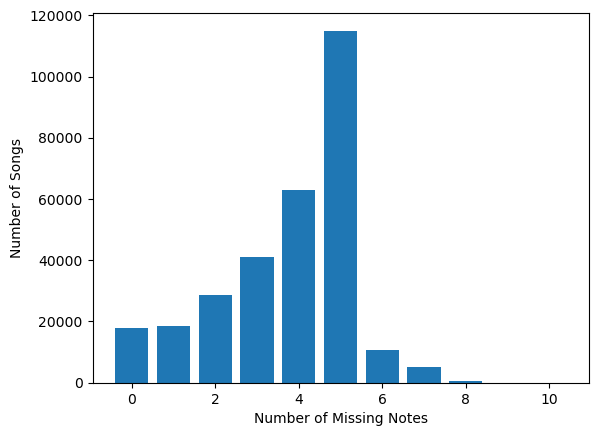

In [11]:
missing=df['missing_notes'].value_counts()
print(missing)
plt.bar(missing.index,missing)
plt.ylabel('Number of Songs')
plt.xlabel('Number of Missing Notes')

Text(0.5, 0, 'Average number of missing notes')

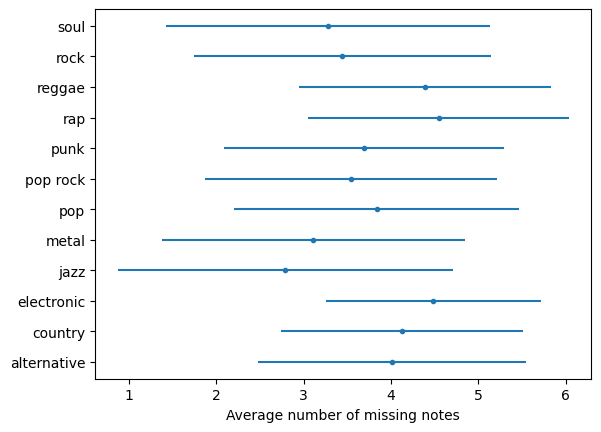

In [12]:
#average and standard deviation of missing note number by genre
genre_means=df[['missing_notes','main_genre']].groupby('main_genre').mean()
genre_std=df[['missing_notes','main_genre']].groupby('main_genre').std()
plt.errorbar(genre_means.missing_notes,genre_means.index,xerr=genre_std.missing_notes,
             ls='None',marker='.')
plt.xlabel('Average number of missing notes')

Text(0.5, 0, 'Average number of missing notes')

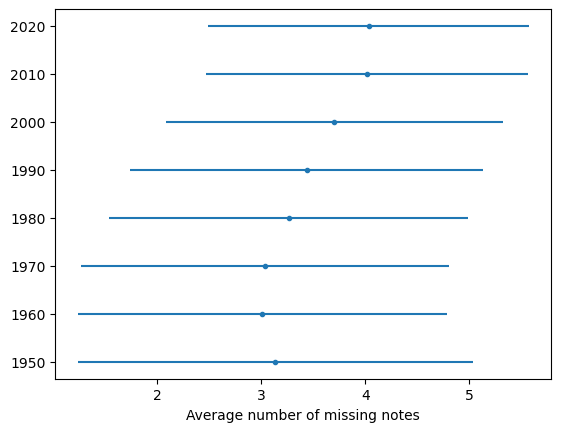

In [13]:
#average and standard deviation of missing note number by decade
genre_means=df[['missing_notes','decade']].groupby('decade').mean()
genre_std=df[['missing_notes','decade']].groupby('decade').std()
plt.errorbar(genre_means.missing_notes,genre_means.index,xerr=genre_std.missing_notes,
             ls='None',marker='.')
plt.xlabel('Average number of missing notes')

There seem to be some interesting trends, like jazz and metal having the fewest average missing notes, or average missing notes seeming to increase over time, but the standard deviations are very large; therefore this might not be useful.

### Songs by Drone Ratio ###


count    300713.000000
mean          0.004196
std           0.003940
min           0.000058
25%           0.002188
50%           0.003085
75%           0.004684
max           0.083333
Name: drone_ratio, dtype: float64


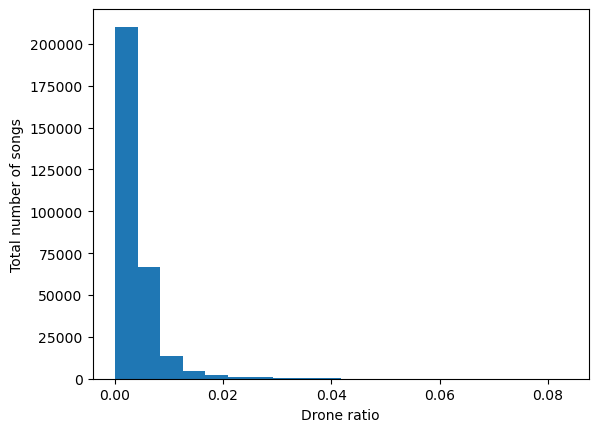

In [14]:
plt.hist(df.drone_ratio,bins=20)
print(df.drone_ratio.describe())
plt.xlabel('Drone ratio')
plt.ylabel('Total number of songs')
plt.show()

<Figure size 640x480 with 0 Axes>

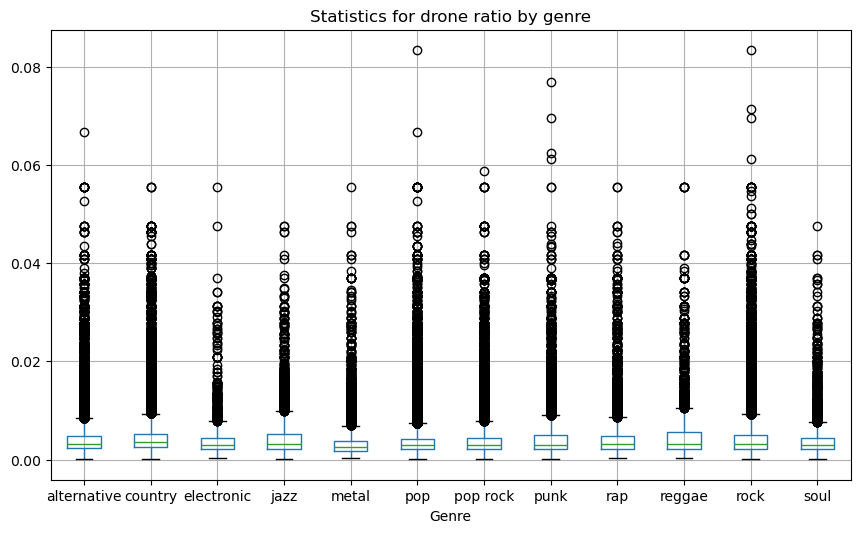

In [15]:
#box and whisker grouped by genre
plt.figure()
df.boxplot(column='drone_ratio',by='main_genre',figsize=(10,6))
plt.xlabel('Genre')
plt.suptitle('')
plt.title('Statistics for drone ratio by genre')
plt.show()

In [16]:
#mean per genre
df[['drone_ratio','main_genre']].groupby('main_genre').mean()

,drone_ratio
main_genre,
alternative,0.004267
country,0.004582
electronic,0.004164
jazz,0.004500
metal,0.003431
pop,0.003824
pop rock,0.003987
punk,0.004494
rap,0.004404


<Figure size 640x480 with 0 Axes>

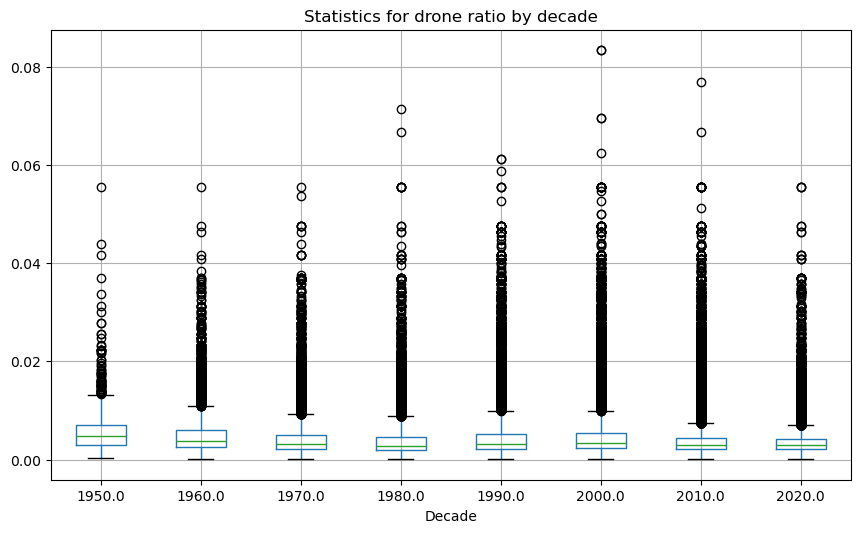

In [17]:
#box and whisker grouped by decade
plt.figure()
df.boxplot(column='drone_ratio',by='decade',figsize=(10,6))
plt.xlabel('Decade')
plt.suptitle('')
plt.title('Statistics for drone ratio by decade')
plt.show()

In [18]:
#mean per decade
df[['drone_ratio','decade']].groupby('decade').mean()

,drone_ratio
decade,
1950.0,0.005843
1960.0,0.004982
1970.0,0.004257
1980.0,0.004135
1990.0,0.004678
2000.0,0.004769
2010.0,0.003844
2020.0,0.003617


Drone ratio is lowest for metal and highest for rap and country. Also very high in the 1950's compared to other decades.

### Songs by average overlap ###

count    300713.000000
mean          0.999473
std           0.393900
min           0.000000
25%           0.756522
50%           0.968750
75%           1.189189
max           4.676768
Name: average_overlap, dtype: float64


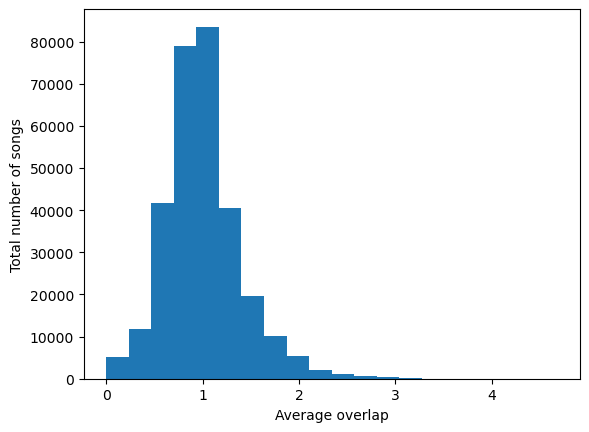

In [19]:
plt.hist(df.average_overlap,bins=20)
print(df.average_overlap.describe())
plt.xlabel('Average overlap')
plt.ylabel('Total number of songs')
plt.show()

There are 5 high outliers with average overalp > 4.5, cut these out of the following plots

<Figure size 640x480 with 0 Axes>

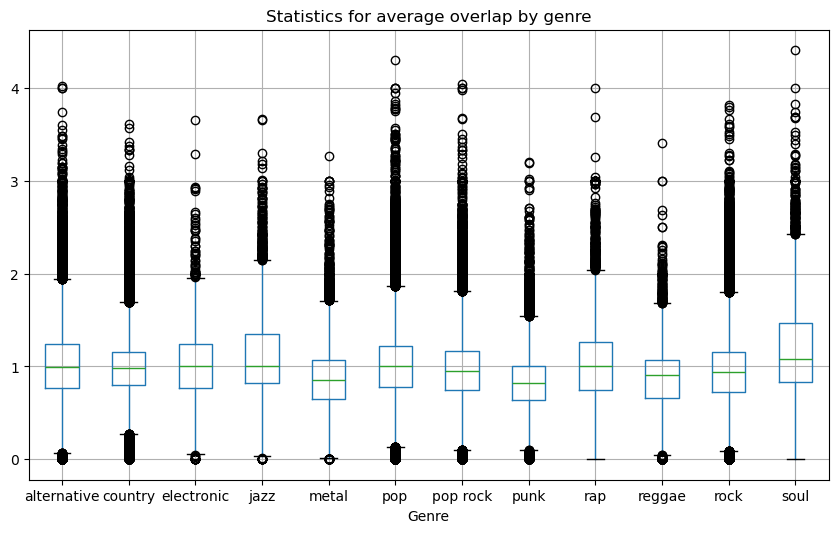

In [20]:
#box and whisker grouped by genre, ignoring high outliers
plt.figure()
df[df['average_overlap']<4.5].boxplot(column='average_overlap',by='main_genre',figsize=(10,6))
plt.xlabel('Genre')
plt.suptitle('')
plt.title('Statistics for average overlap by genre')
plt.show()

In [21]:
#mean per genre
df[['average_overlap','main_genre']].groupby('main_genre').mean()

,average_overlap
main_genre,
alternative,1.032597
country,1.010935
electronic,1.026853
jazz,1.120501
metal,0.880677
pop,1.025013
pop rock,0.986555
punk,0.843430
rap,1.042968


<Figure size 640x480 with 0 Axes>

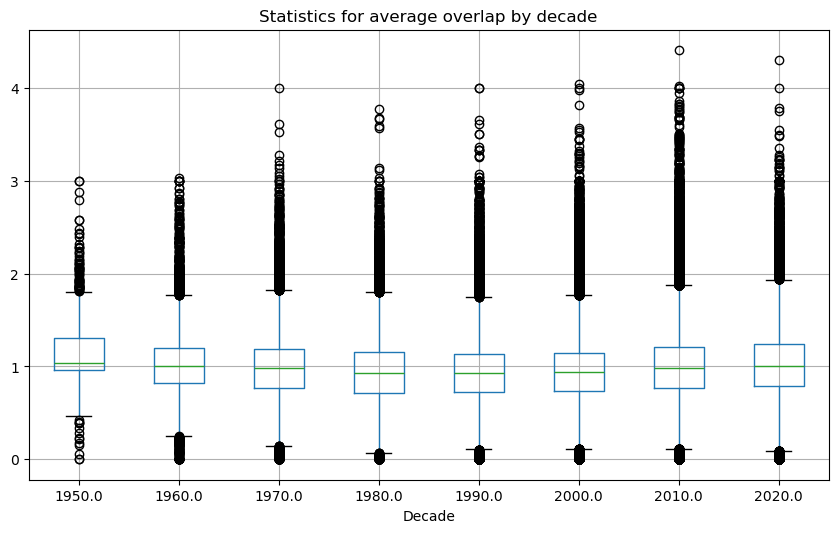

In [22]:
#box and whisker grouped by decade, ignoring high outliers
plt.figure()
df[df['average_overlap']<4.5].boxplot(column='average_overlap',by='decade',figsize=(10,6))
plt.xlabel('Decade')
plt.suptitle('')
plt.title('Statistics for average overlap by decade')
plt.show()

In [23]:
#mean per decade
df[['average_overlap','decade']].groupby('decade').mean()

,average_overlap
decade,
1950.0,1.145024
1960.0,1.027910
1970.0,1.011746
1980.0,0.964456
1990.0,0.957895
2000.0,0.965085
2010.0,1.017725
2020.0,1.043185


Soul seems to have the highest average overalp statistics while metal and punk are the lowest. The trend over time is very similar to that of the drone ratio trend.

### Genres and decades by most common note ###

Scatter plot of the frequency that a particular note is among the most popular notes of a song by genre:

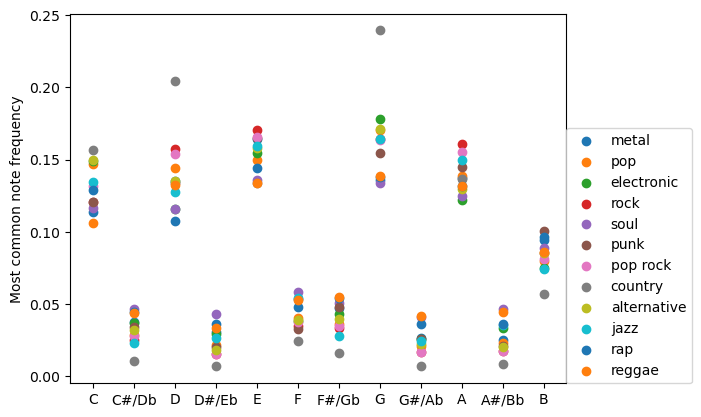

In [25]:
genres=df.main_genre.unique()
genre_dict=dict.fromkeys(genres,0)
for g in genres:
    sub_df=df[df['main_genre']==g]
    notes=np.array([0,0,0,0,0,0,0,0,0,0,0,0])
    for n in range(12):
        notes[n]=sub_df[sub_df['most_common_notes'].apply(lambda x: n in x)].shape[0]
        genre_dict[g]=notes/sum(notes)

semitones=['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
plt.figure()
for g in genres:
    plt.scatter(semitones,genre_dict[g],label=g)
plt.legend(loc=(1,0))
plt.ylabel('Most common note frequency')
plt.show()



Country seems to have some differences. Now, doing the same plot by decade:

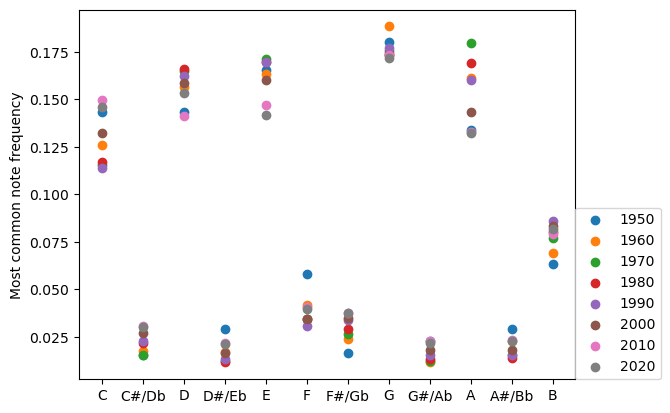

In [26]:
decs=df.decade.unique()
decs.sort()
dec_dict=dict.fromkeys(decs,0)
for d in decs:
    sub_df=df[df['decade']==d]
    notes=np.array([0,0,0,0,0,0,0,0,0,0,0,0])
    for n in range(12):
        notes[n]=sub_df[sub_df['most_common_notes'].apply(lambda x: n in x)].shape[0]
        dec_dict[d]=notes/sum(notes)

semitones=['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
plt.figure()
for d in decs:
    plt.scatter(semitones,dec_dict[d],label=int(d))
plt.legend(loc=(1,0))
plt.ylabel('Most common note frequency')
plt.show()

Maybe the 1950's are a bit different? Overall not sure if this is a useful feature.

### Genres and decades by average note frequency vector ###

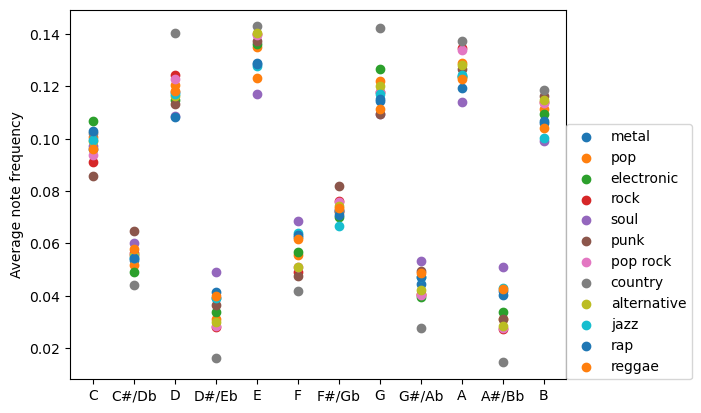

In [27]:
genre_means=df[['main_genre','note_frequency_vec']].groupby('main_genre').mean()
genres=df.main_genre.unique()
semitones=['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
plt.figure()
for g in genres:
    plt.scatter(semitones,genre_means.loc[g,'note_frequency_vec'],label=g)
plt.legend(loc=(1,0))
plt.ylabel('Average note frequency')
plt.show()

Soul and country usually seem to be at extremens.

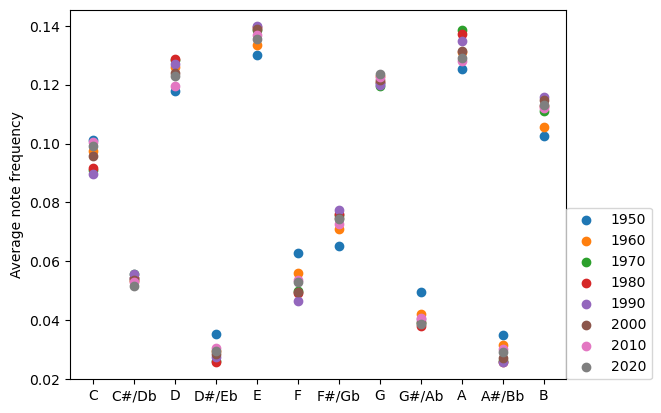

In [28]:
dec_means=df[['decade','note_frequency_vec']].groupby('decade').mean()
decs=df.decade.unique()
decs.sort()
semitones=['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
plt.figure()
for d in decs:
    plt.scatter(semitones,dec_means.loc[d,'note_frequency_vec'],label=int(d))
plt.legend(loc=(1,0))
plt.ylabel('Average note frequency')
plt.show()

The 1950's always seem to be at extremes. Like the most common frequency note, not sure how useful a feature average note frequencies are.

In [ ]:
from collections import deque 
from itertools import permutations

def transpose_chord_up(chord_vector, num_semitones):
    # transpose the input chord_vector up by num_semitones
    d = deque(chord_vector)
    d.rotate(num_semitones)
    return(list(d))

def is_major_triad(chord_vector):
    # return true if chord_vector is a major triad
    C_triad = chord_degrees['C']
    for i in range(12):
        if np.array_equal(chord_vector[::-1], 
                          transpose_chord_up(C_triad,i)):
            return 1
    return 0

vec=[0,0,1,0,0,1,0,0,0,1,0,0] #D
transpositions=[]
for i in range(12):
    transpositions.append(transpose_chord_up(vec,i))

def new_triads(mat):
    triads=[list(row) in transpositions for row in np.transpose(mat)]
    return np.mean(triads)

def major_triads(chord_matrix):
    # return a binary vector indicating where simple major triads occur
    triads=[is_major_triad(c) for c in np.transpose(chord_matrix)]
    return np.mean(triads)

In [77]:
import timeit
for i in range(10):
    a1=timeit.timeit("major_triads(mat)","from __main__ import major_triads, mat",number=1000)
    a2=timeit.timeit("new_triads(mat)","from __main__ import new_triads, mat",number=1000)
    print(a1,a2)


1.6153505999827757 0.17350330000044778
1.545429999998305 0.15822000001207925
1.527313900005538 0.1582367999944836
1.533579400012968 0.1571010000188835
1.5245169999834616 0.15756259998306632
1.5510290000238456 0.1568750999867916
1.5129165999824181 0.15894969998043962
1.5533308000012767 0.1571469999908004
1.5049164000083692 0.15604219998931512
1.5452763000212144 0.15932649999740534


In [83]:
#insert major triad ratio into df
df.insert(8,'maj_triad_ratio',df['chord_matrix'].apply(new_triads))

### Songs by major triad ratio ###

count    300713.000000
mean          0.652089
std           0.245245
min           0.000000
25%           0.511811
50%           0.686047
75%           0.818182
max           1.000000
Name: maj_triad_ratio, dtype: float64


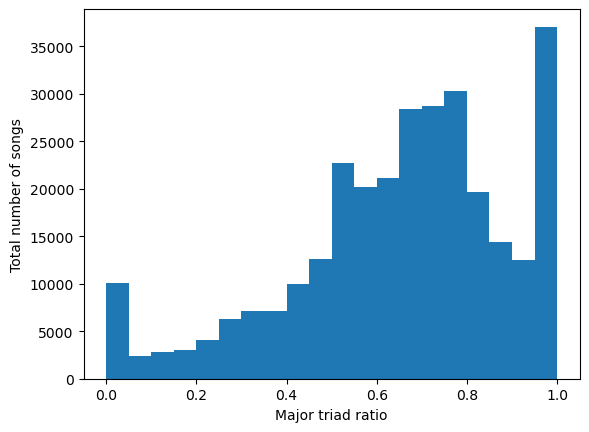

In [84]:
plt.hist(df.maj_triad_ratio,bins=20)
print(df.maj_triad_ratio.describe())
plt.xlabel('Major triad ratio')
plt.ylabel('Total number of songs')
plt.show()

<Figure size 640x480 with 0 Axes>

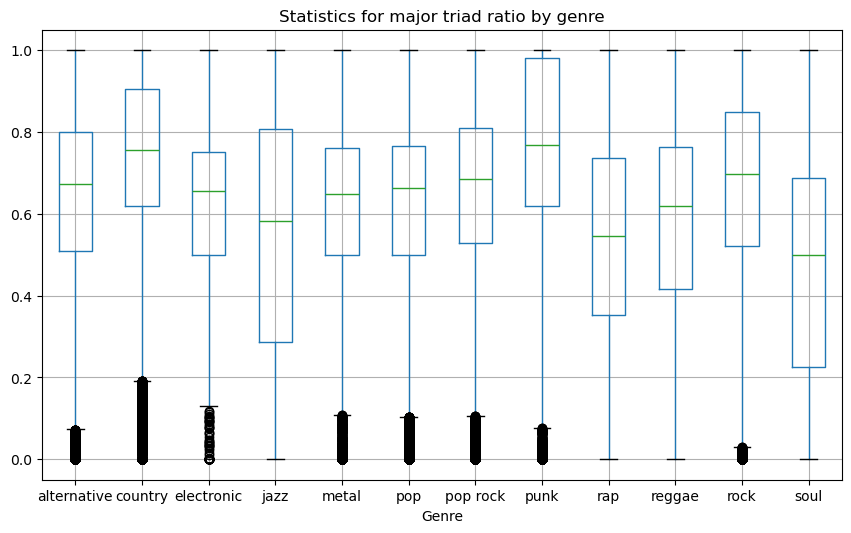

In [85]:
#box and whisker grouped by genre
plt.figure()
df.boxplot(column='maj_triad_ratio',by='main_genre',figsize=(10,6))
plt.xlabel('Genre')
plt.suptitle('')
plt.title('Statistics for major triad ratio by genre')
plt.show()

Text(0.5, 0, 'Average number of missing notes')

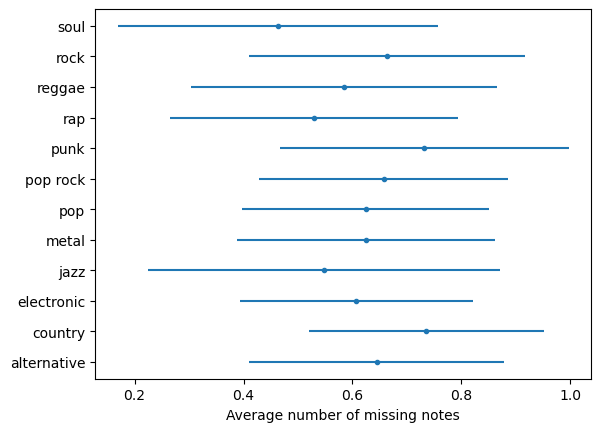

In [ ]:
#plot of means and standard deviations by genre
triad_genre_means=df[['maj_triad_ratio','main_genre']].groupby('main_genre').mean()
triad_genre_std=df[['maj_triad_ratio','main_genre']].groupby('main_genre').std()
plt.errorbar(triad_genre_means.maj_triad_ratio,triad_genre_means.index,
             xerr=triad_genre_std.maj_triad_ratio, ls='None',marker='.')
plt.xlabel('Average major triad ratio')

Some very big differences between genres, punk and country are quite high while soul is quite low

<Figure size 640x480 with 0 Axes>

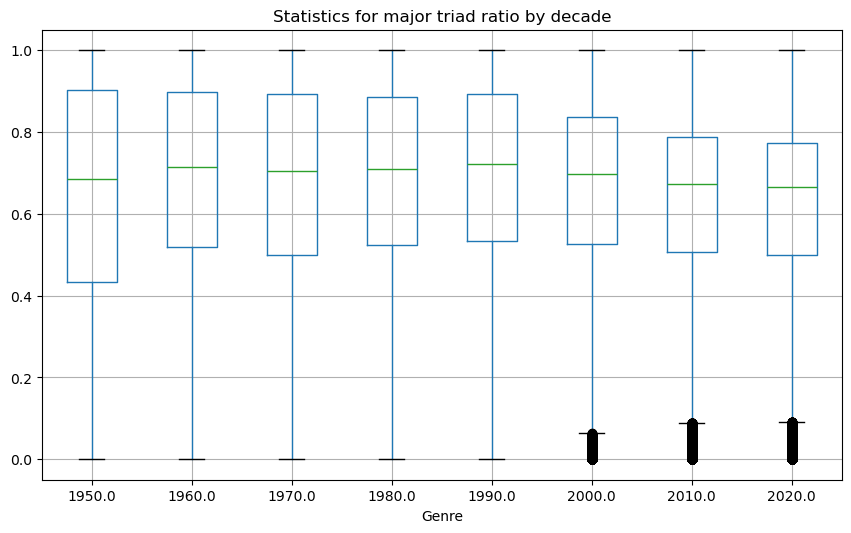

In [88]:
#box and whisker grouped by decade
plt.figure()
df.boxplot(column='maj_triad_ratio',by='decade',figsize=(10,6))
plt.xlabel('Genre')
plt.suptitle('')
plt.title('Statistics for major triad ratio by decade')
plt.show()

Text(0.5, 0, 'Average major triad ratio')

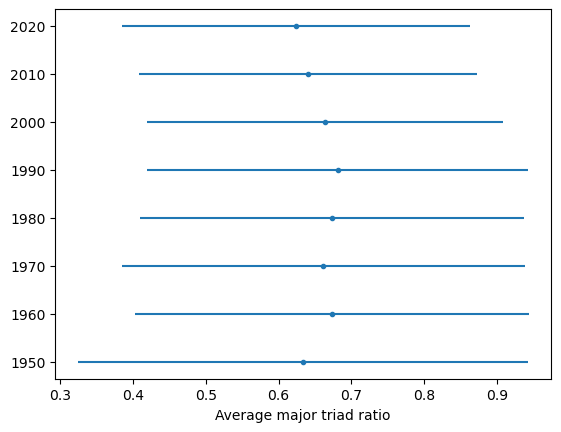

In [89]:
#plot of means and standard deviations by genre
triad_dec_means=df[['maj_triad_ratio','decade']].groupby('decade').mean()
triad_dec_std=df[['maj_triad_ratio','decade']].groupby('decade').std()
plt.errorbar(triad_dec_means.maj_triad_ratio,triad_dec_means.index,
             xerr=triad_dec_std.maj_triad_ratio, ls='None',marker='.')
plt.xlabel('Average major triad ratio')

Spreads have seemed to decrease over time but no clear direcitonal trends.